#Data

In [2]:
names = open('names.txt', 'r').read().split('\n')
print(names[:5])

['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import torch

In [8]:
chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
chars.insert(0, ' ')
s2i = {s:i for i,s in enumerate(chars)}
i2s = {i:s for s,i in s2i.items()}

#Simple Bigram Model

In [3]:
bi_counter = {}
for name in names:
  s = ['<S>'] + list(name) + ['<E>']
  for i in range(len(s) - 1):
    c1 = s[i]
    c2 = s[i + 1]
    bi = (c1, c2)
    bi_counter[bi] = bi_counter.get(bi, 0) + 1

In [4]:
sorted_bigrams = list(reversed(sorted(bi_counter.items(), key = lambda t: t[1])))

In [5]:
print(sorted_bigrams)

[(('n', '<E>'), 6763), (('a', '<E>'), 6640), (('a', 'n'), 5438), (('<S>', 'a'), 4410), (('e', '<E>'), 3983), (('a', 'r'), 3264), (('e', 'l'), 3248), (('r', 'i'), 3033), (('n', 'a'), 2977), (('<S>', 'k'), 2963), (('l', 'e'), 2921), (('e', 'n'), 2675), (('l', 'a'), 2623), (('m', 'a'), 2590), (('<S>', 'm'), 2538), (('a', 'l'), 2528), (('i', '<E>'), 2489), (('l', 'i'), 2480), (('i', 'a'), 2445), (('<S>', 'j'), 2422), (('o', 'n'), 2411), (('h', '<E>'), 2409), (('r', 'a'), 2356), (('a', 'h'), 2332), (('h', 'a'), 2244), (('y', 'a'), 2143), (('i', 'n'), 2126), (('<S>', 's'), 2055), (('a', 'y'), 2050), (('y', '<E>'), 2007), (('e', 'r'), 1958), (('n', 'n'), 1906), (('y', 'n'), 1826), (('k', 'a'), 1731), (('n', 'i'), 1725), (('r', 'e'), 1697), (('<S>', 'd'), 1690), (('i', 'e'), 1653), (('a', 'i'), 1650), (('<S>', 'r'), 1639), (('a', 'm'), 1634), (('l', 'y'), 1588), (('<S>', 'l'), 1572), (('<S>', 'c'), 1542), (('<S>', 'e'), 1531), (('j', 'a'), 1473), (('r', '<E>'), 1377), (('n', 'e'), 1359), (('i'

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32)
for name in names:
  s = [' '] + list(name) + [' ']
  for i in range(len(s) - 1):
    index1 = s2i[s[i]]
    index2 = s2i[s[i + 1]]
    N[index1, index2] += 1

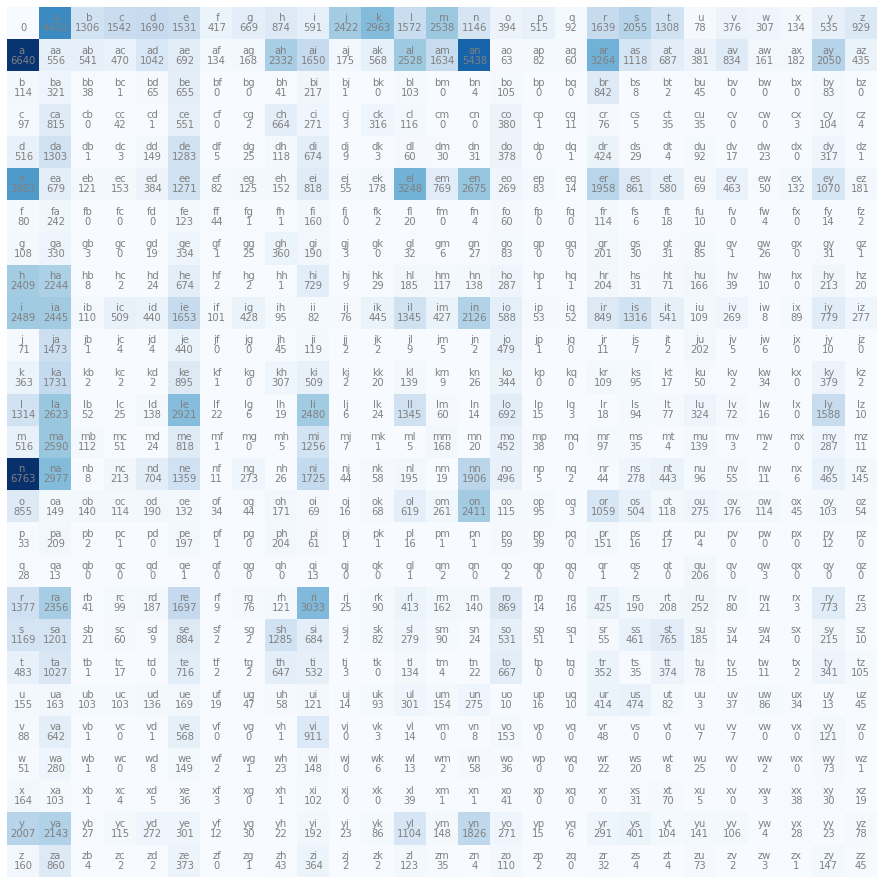

In [10]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = i2s[i] + i2s[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [11]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [12]:
g = torch.Generator().manual_seed(2147483647)
i = 0

for k in range(20):
  new_name = ''

  while True:
    p = P[i]
    i = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    new_name += i2s[i]

    if i == 0:
      new_name = new_name[:-1]
      print(new_name)
      break

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl
h
br
a
jayn
ilemannariaenien
be
f
akiinela
trttanakeroruceyaaxatona
lamoynayrkiedengin


##Negative Log Likelyhood

In [13]:
nll = 0.0
n = 0
for name in names:
  s = [' '] + list(name) + [' ']
  for i in range(len(s) - 1):
    index1 = s2i[s[i]]
    index2 = s2i[s[i + 1]]
    nll -= torch.log(P[index1, index2])
    n += 1
print(f'{nll=}')
print(f'{nll/n}')

nll=tensor(559951.5625)
2.4543561935424805


#Neural Network Bigram Model

In [51]:
xs, ys = [], []
for name in names:
  s = [' '] + list(name) + [' ']
  for i in range(len(s) - 1):
    index1 = s2i[s[i]]
    index2 = s2i[s[i + 1]]
    xs.append(index1)
    ys.append(index2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [100]:
import torch.nn.functional as F
x_enc = F.one_hot(xs, num_classes=27).float()

In [110]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
x_enc @ W

tensor([[ 1.9217, -0.1818,  1.5220,  0.5464,  0.4086, -1.9692, -0.8918,  0.3296,
         -0.2513,  0.5503, -0.7517, -0.0066, -0.6311,  1.3431,  0.0380, -0.7165,
          1.7206, -0.5215, -0.2325,  1.0774, -0.7602,  0.0090, -0.7922,  1.2307,
         -0.5276, -1.3207, -0.7065]], grad_fn=<MmBackward0>)

In [111]:
# gradient descent
for k in range(300):
  # forward pass
  x_enc = F.one_hot(xs, num_classes=27).float()
  logits = x_enc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim=True)
  loss = -probs[torch.arange(len(probs)), ys].log().mean() + 0.001 * (W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data -= 50 * W.grad

3.759920358657837
3.3718738555908203
3.154751777648926
3.021059989929199
2.9283947944641113
2.861093044281006
2.8104305267333984
2.7708170413970947
2.738802671432495
2.712242603302002
2.6897668838500977
2.67047119140625
2.653733253479004
2.639101505279541
2.6262333393096924
2.6148574352264404
2.6047515869140625
2.595731019973755
2.587642192840576
2.580354690551758
2.5737600326538086
2.5677669048309326
2.562297821044922
2.5572876930236816
2.5526814460754395
2.548431873321533
2.544499158859253
2.5408501625061035
2.5374553203582764
2.534290313720703
2.5313332080841064
2.5285658836364746
2.5259716510772705
2.523536205291748
2.5212461948394775
2.5190906524658203
2.5170586109161377
2.515141010284424
2.513329267501831
2.511615514755249
2.5099923610687256
2.5084543228149414
2.5069940090179443
2.5056071281433105
2.5042881965637207
2.503032684326172
2.5018362998962402
2.50069522857666
2.499605894088745
2.4985649585723877
2.4975697994232178
2.496616840362549
2.495703935623169
2.494828939437866
2.

In [112]:
g = torch.Generator().manual_seed(2147483647)
i = 0

for k in range(20):
  new_name = ''

  while True:
    x_enc = F.one_hot(torch.tensor([i]), num_classes=27).float()
    logits = x_enc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)

    i = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    new_name += i2s[i]

    if i == 0:
      new_name = new_name[:-1]
      print(new_name)
      break

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jionatien
egushk
ga
t
a
jayn
ilemannariaenien
be
f
akiinela
trttanakeroruceyaaxatona
lamoynayrkhadengin
